## Kaggle - Bike Sharing Demand 

<br>

 **data from : [
Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand)**

<br>

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter  
- holiday - whether the day is considered a holiday  
- workingday - whether the day is neither a weekend nor holiday 
- weather 
 - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
 - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
 - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
 - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals, casual + registered = count
<br><br>



**Evaluation**

<br>
Submissionsare evaluated one the Root Mean Squared Logarithmic Error (RMSLE).

In [251]:
import pandas as pd
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib.inline # 주피터에서 그래프를 그리기 위한 코드 
plt.styple.use('ggplot') # R의 ggplot 형태로 그래프 출력  
mpl.rcParams['axes.unique_minus'] = False # 그래프에서 음수가 나오지 않는 경우 방지

UsageError: Line magic function `%matplotlib.inline` not found.


# 탐색적 데이터 분석 

### 0. 데이터 불러오기 및 결측치 확인


In [292]:
file_path = r'C:\Users\709-000\Desktop\bike-sharing-demand'

In [253]:
train  = pd.read_csv(file_path + '/train.csv')
test = pd.read_csv(file_path + '/test.csv')

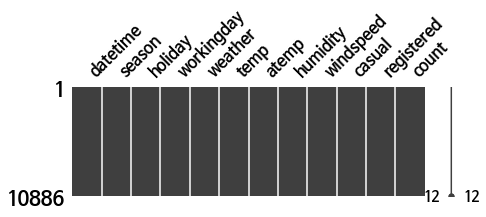

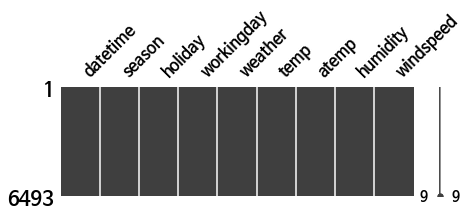

In [254]:
import missingno as msno

msno.matrix(train, figsize=(7,2))
msno.matrix(test, figsize=(7,2))

 - train, test 모든 변수에 Null 값이 없음을 확인
 

In [255]:
train.head() # 데이터 속성 확인, 참고로 count = casual + registered 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## 1. 데이터 전처리 및 변수확인

In [256]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


 - 연속형 변수들의 변수 분포를 확인한다
    - 1. temp : 평균온도는 20.23(섭씨)이고, 표준편차는 7.79, 최소, 최댓값은 각각 0.82, 41
    - 2. atemp : 평균체감온도는 23.65(섭씨)이고, 표준편차는 8.47, 최소 최대값은 각각 0.76, 45 
     - 온도 관련 변수는 체감온도가 온도에 비해 조금더 분포가 큰 것으로 나타나고 
     - 상식적으로 두 변수는 상관관계가 높게 나타날 것으로 예상된다.
    - 3. humidity : 평균습도는 61.8이고, 표준편차는 19.24, 최소 최대값은 각각 0, 100
    - 4. windspeed : 평균풍속은 12.7. 표준편차는 8.16, 최소 최대값은 각각 7, 56
 - 각 피처의 속성이 다르기 떄문에 데이터 정규화가 필요해 보인다.. 

### 1.1 datetime 변수를 연, 월, 일, 시로 분리

In [257]:
train["datetime"] = pd.to_datetime(train["datetime"]) # 문자열을 데이트타입으로 변경 

train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour

In [258]:
train.head(1) # 데이터 확인 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0


In [259]:
test["datetime"] = pd.to_datetime(test["datetime"]) # 문자열을 데이트타입으로 변경 

test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour

In [260]:
test.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,2011-01-20,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0


### 변수별 count 확인 : 1. season, holiday, workindgday, weather

[Text(0.5, 1.0, '날씨별 대여량')]

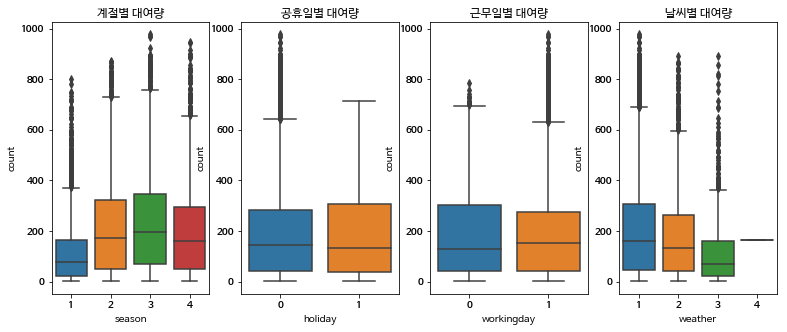

In [261]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(ncols=4)
fig.set_size_inches(13, 5)

sns.boxplot(x="season", y="count", data=train,ax=ax1)
sns.boxplot(x="holiday", y="count", data=train,ax=ax2)
sns.boxplot(x="workingday", y="count", data=train,ax=ax3)
sns.boxplot(x="weather", y="count", data=train,ax=ax4)

ax1.set(title="계절별 대여량")
ax2.set(title="공휴일별 대여량")
ax3.set(title="근무일별 대여량")
ax4.set(title="날씨별 대여량")

- season : 시즌별로 가을에 대여량이 많다. 
- holiday : 공휴일에 따른 대여량은 차이가 없는것으로 보인다 
- workindgdayy : 근무일에 따른 대여량도 차이가 없는것으로 보인다.
- weather : 날씨를 보면 당연하게도 아주 깨끗한 날씨(1)에 가장 많은 대여량을 보이고,
 약간의 눈, 비(3)가오는 날에 대여량이 낮다. 또한 아주 많은 비가 오거나 우박이 내리는(4)날씨는 대여량이 거의 없다.
 
 - season, weather 피처는 대여량에 영향을 줄 것으로 보인다.
 - 다만 각 피처별 시간대별 패턴을 봐야할 것 같다.

### 변수별 count 확인 : 2. year, month, day, hour

[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '시간별 대여량')]

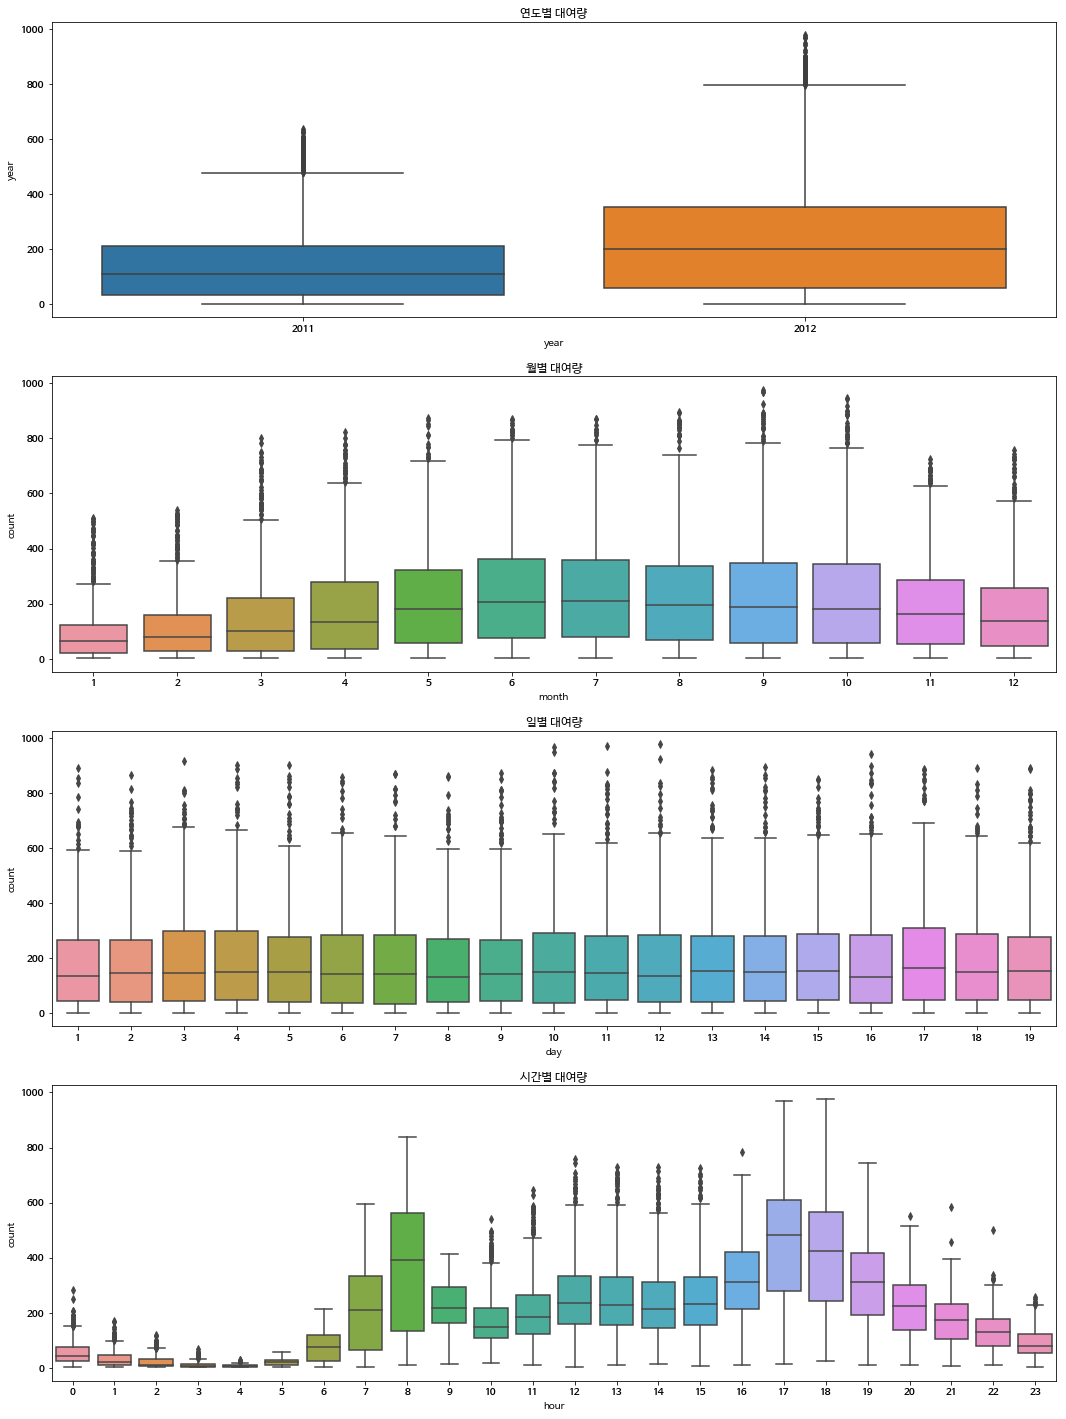

In [262]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(nrows=4)
fig.set_size_inches(18, 25)

sns.boxplot(x="year", y="count", data=train,ax=ax1)
sns.boxplot(x="month", y="count", data=train,ax=ax2)
sns.boxplot(x="day", y="count", data=train,ax=ax3)
sns.boxplot(x="hour", y="count", data=train,ax=ax4)

ax1.set(ylabel='year',title="연도별 대여량")
ax2.set(xlabel='month',title="월별 대여량")
ax3.set(xlabel='day', title="일별 대여량")
ax4.set(xlabel='hour', title="시간별 대여량")

 - 연도별 대여량은 2012년에 더 많다.
 - 월별 대여량은 6월에 가장 많고 7~10월에 대여량이 많다. 반면 11월 부터 대여량이 감소해 1월에 가장 적은 대여량이 나타나는 것을 볼 수 있다.
 - 일별 대여량은 train 셋에는 19일 까지 밖에 없다. 즉 나머지 날짜에 대한 정보가 없으므로 사용할 수 없다.
 - 시간별 대여량은 8시와 17~18시 즉 출퇴근시간에 대여량이 많은 것을 볼 수 있다.

### 변수별 count 확인 : 3. temp, atemp, humidity, windspeed

[Text(0.5, 0, 'windspeed'), Text(0.5, 1.0, '풍속 분포')]

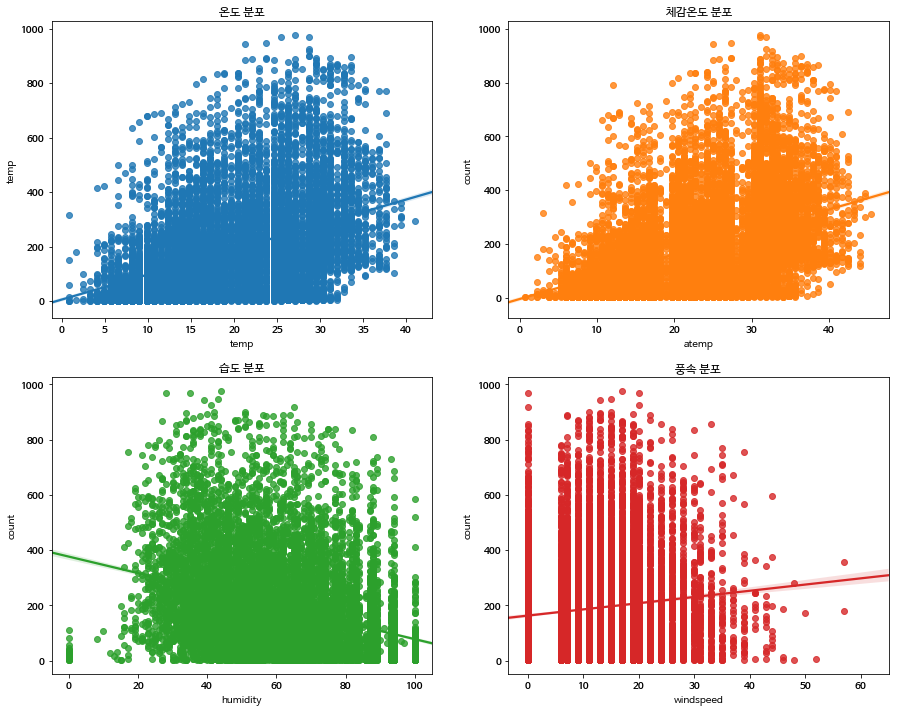

In [263]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15, 12)

sns.regplot(x="temp", y="count", data=train,ax=ax1)
sns.regplot(x="atemp", y="count", data=train,ax=ax2)
sns.regplot(x="humidity", y="count", data=train,ax=ax3)
sns.regplot(x="windspeed", y="count", data=train,ax=ax4)

ax1.set(ylabel='temp',title="온도 분포")
ax2.set(xlabel='atemp',title="체감온도 분포")
ax3.set(xlabel='humidity', title="습도 분포")
ax4.set(xlabel='windspeed', title="풍속 분포")

- windspeed 변수의 경우 0에 숫자가 많이 몰려있음을 알 수 있다. 풍속이 측정되지 않거나 일정 수준 이하라면 0으로 처리하는 것으로 보인다. 따라서 다른 변수들로 부터 풍속을 채워넣을 필요가 있다.

In [264]:
# 풍속이 0인 것과 아닌 것의 세트를 나누어 준다.
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 16)
(9573, 16)


In [265]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):

    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]

    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터 타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data

In [266]:
train = predict_windspeed(train)
#test = predict_windspeed(test)

C:\AN\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\AN\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\AN\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


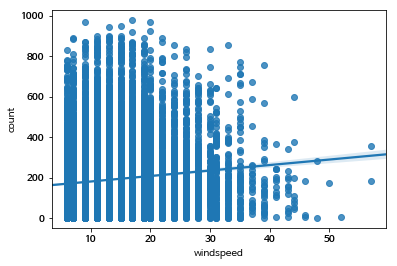

In [267]:
sns.regplot(x="windspeed", y="count", data=train)

- 풍속 데이터의 0값을 랜덤포레스트회귀모델로 예측한 값으로 채워넣었다.

### 변수별 count 확인 4 : 

     공휴일 - 시간별 대여량 
     휴일 - 시간별 대여량
     날씨 - 시간별 대여량
     계절 - 시간별 대여량 

[Text(0.5, 0, 'windspeed'), Text(0.5, 1.0, '계절별-시간별 대여량')]

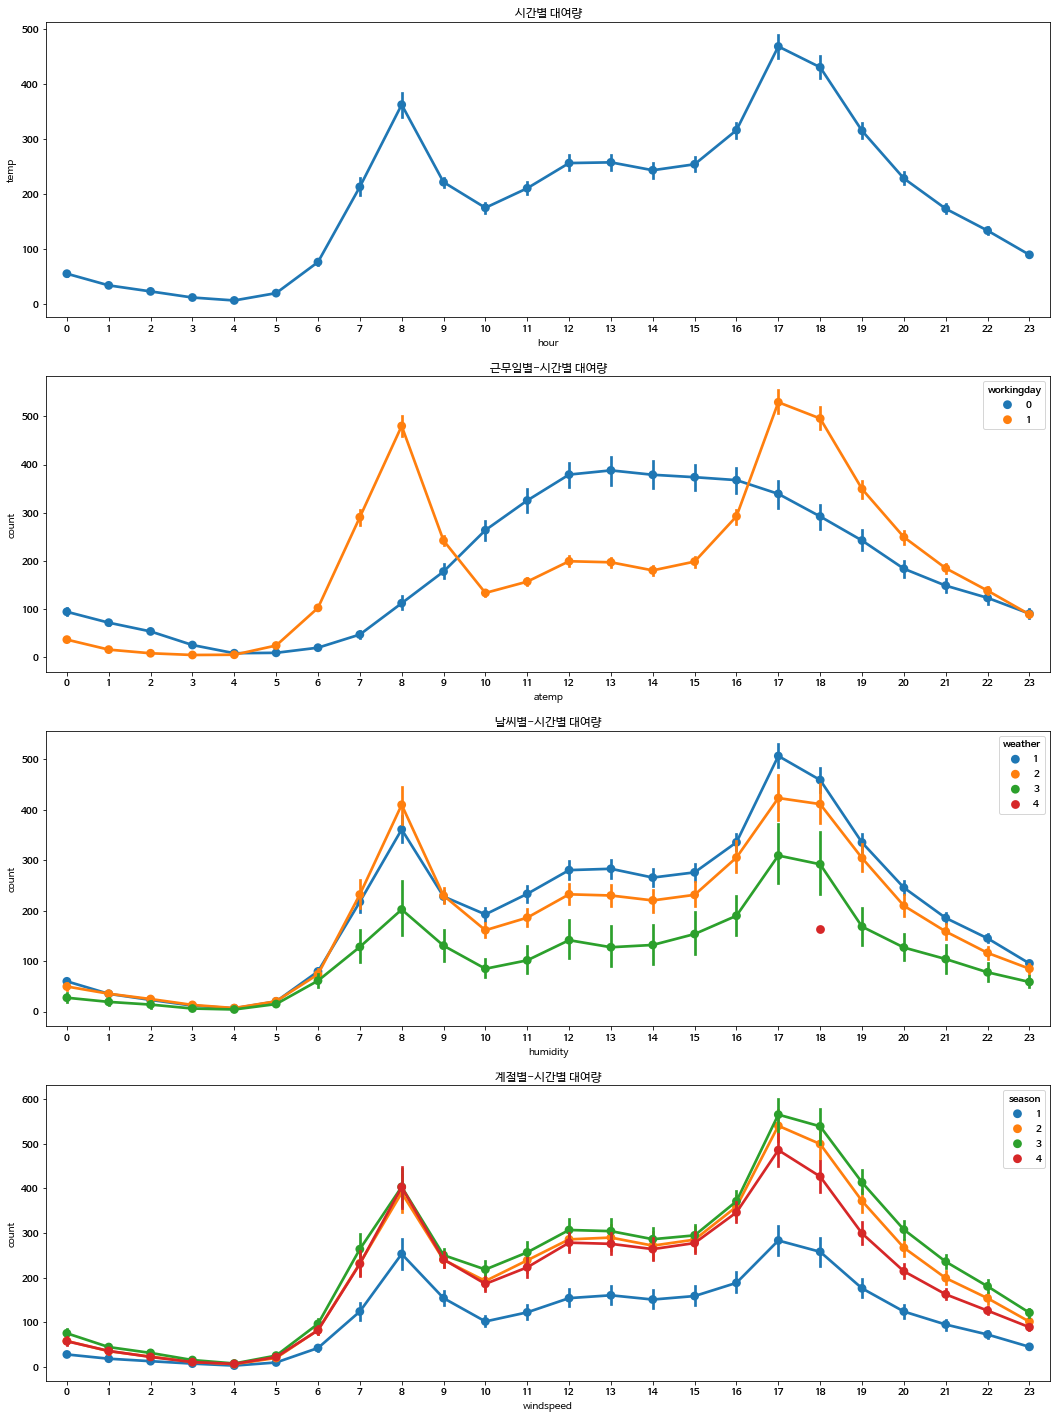

In [268]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18,25)

sns.pointplot(data=train, x="hour", y="count", ax=ax1)
sns.pointplot(data=train, x="hour", y="count", hue="workingday", ax=ax2)
sns.pointplot(data=train, x="hour", y="count", hue="weather", ax=ax3)
sns.pointplot(data=train, x="hour", y="count", hue="season", ax=ax4)

ax1.set(ylabel='temp',title="시간별 대여량")
ax2.set(xlabel='atemp',title="근무일별-시간별 대여량")
ax3.set(xlabel='humidity', title="날씨별-시간별 대여량")
ax4.set(xlabel='windspeed', title="계절별-시간별 대여량")

- 다른 그림과 달리 근무일별 - 시간별에서 대여량의 패턴이 다르게 나타나는 것읇 볼 수 있다.

### 변수별 상관관계 확인 

In [269]:
corrMatt = train[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]]
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949   0.002619   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.033457   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.106908   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091003   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.342575   
windspeed   0.002619 -0.033457  0.106908    0.091003 -0.342575   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.105364   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.105364  
count       1.000000  


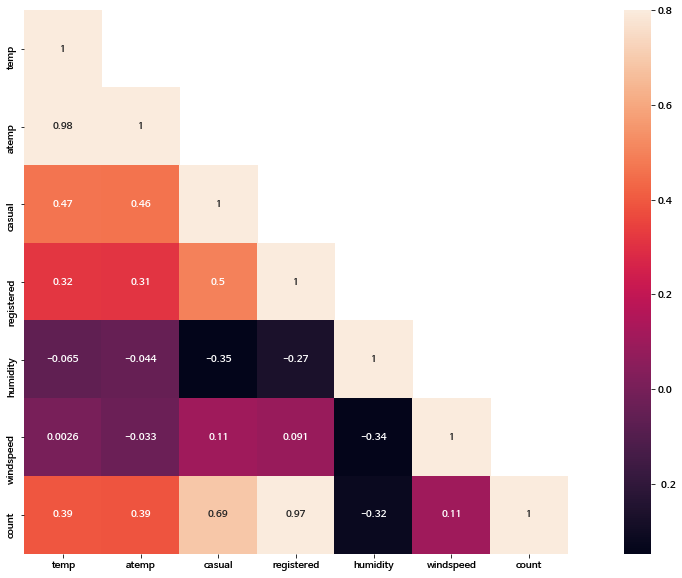

In [270]:

fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

- 온도, 습도, 풍속은 연관관계가 약하다.
- 대여량과 가장 연관이 높은 건 registered 로 등록 된 대여자가 많지만, test 데이터에는 이 값이 없다.
- atemp와 temp는 0.98로 상관관계가 높아 피처를 같이 쓰지 않을 것을 고려해봄직 하다

### 변수별 count 확인 5 : count

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([  1,   1,   1, ..., 968, 970, 977], dtype=int64)),
 (169.82942673231383, 191.5741319125482, 0.9372682766213174))

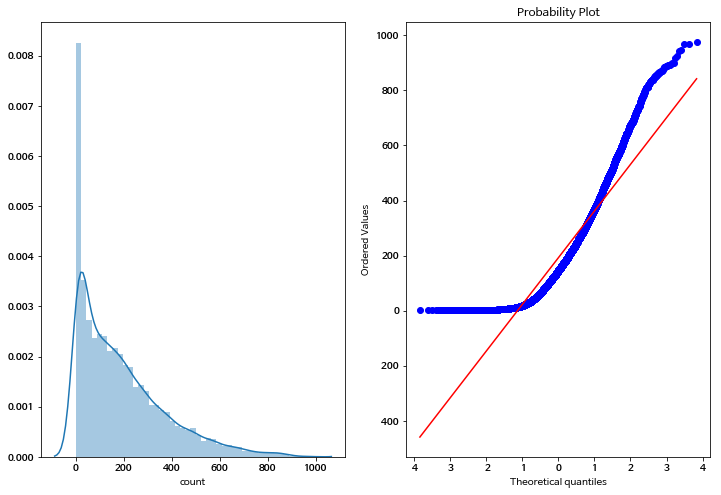

In [272]:
from scipy import stats

figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12, 8)

sns.distplot(train["count"], ax=ax1)
stats.probplot(train["count"], dist='norm', fit=True, plot=ax2)

-  count 변수의 분포는 왼쪽으로 치우쳐져 있는 형태로 머신러닝에 적합한 형태로 만들기위해 log를 씌워본다.

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.87626461, 6.87832647,
         6.88550967])),
 (1.3647396459244168, 4.591363690454027, 0.9611793780126955))

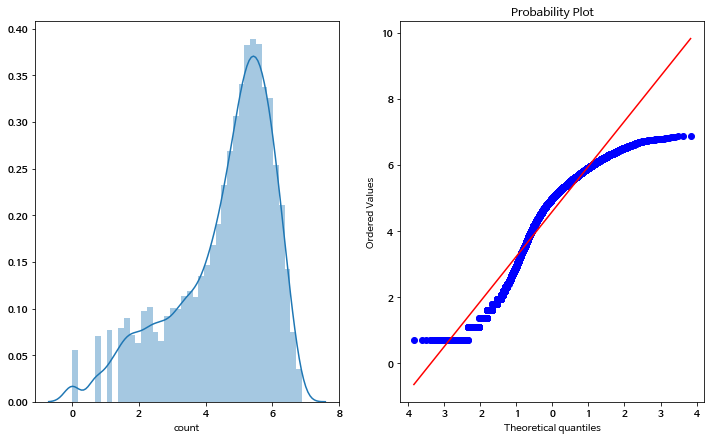

In [273]:
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12, 7)

sns.distplot(np.log(train["count"]), ax=ax1)
stats.probplot(np.log1p(train["count"]), dist='norm', fit=True, plot=ax2)

 - 로그를 씌운 후 형태를 보면 오른쪽으로 약간 치우쳐져 있긴 하지만, 좀더 정규분포에 가까운 모양을 갖음을 알 수 있다.
 - 다만 첫 모델링 과정에서 로그를 씌우지 않고 진행해본다. 

In [274]:
# train["count"] = (np.log(train["count"]+1)) # 0을 log취하면 계산이 불가능하기 때문에 임의로 1을 더해줌 

# 변수 선택 및 모델링

In [275]:
# 연속형 feature와 범주형 feature 
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
# 범주형 feature의 type을 category로 변경해 준다.

categorical_feature_names = ["season","holiday","workingday","weather",
                            "month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [276]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null category
holiday       10886 non-null category
workingday    10886 non-null category
weather       10886 non-null category
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
year          10886 non-null category
month         10886 non-null category
day           10886 non-null int64
hour          10886 non-null category
dtypes: category(7), datetime64[ns](1), float64(3), int64(5)
memory usage: 841.8 KB


## 1. 모델에 사용할 변수 선택

In [277]:
feature_names = ["season", "weather", "atemp", "humidity", "windspeed",
                 "year", "hour", "holiday", "workingday"]

In [278]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 9)


,season,weather,atemp,humidity,windspeed,year,hour,holiday,workingday
0,1,2,12.880,75,6.0032,2011,5,0,0
1,1,1,19.695,76,16.9979,2011,10,0,0
2,1,1,16.665,81,19.0012,2011,11,0,0
3,1,1,21.210,77,19.0012,2011,12,0,0
4,1,2,22.725,72,19.9995,2011,13,0,0


In [279]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 9)


,season,weather,atemp,humidity,windspeed,year,hour,holiday,workingday
0,1,1,11.365,56,26.0027,2011,0,0,1
1,1,1,13.635,56,0.0000,2011,1,0,1
2,1,1,13.635,56,0.0000,2011,2,0,1
3,1,1,12.880,56,11.0014,2011,3,0,1
4,1,1,12.880,56,11.0014,2011,4,0,1


In [280]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

# 모델 평가 방법 :  RMSLE

<br>

과대평가 된 항목보다는 과소평가 된 항목에 페널티를 준다.

오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root)으로 값이 작을수록 정밀도가 높다.

0에 가까운 값이 나올수록 정밀도가 높은 값이다.

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE)

$$ \sqrt{\frac{1}{n} \sum{i=1}n (\log(pi + 1) - \log(a_i+1))2 } $$

- \({n}\) is the number of hours in the test set
- \(p_i\) is your predicted count
- \(a_i\) is the actual count
- \(\log(x)\) is the natural logarithm

- 좀 더 자세한 설명은 : RMSLE cost function

- 잔차(residual)에 대한 평균에 로그를 씌운 값이다. => 과대평가 된 항목보다 과소평가 된 항목에 페널티를 주기 위해

- 정답에 대한 오류를 숫자로 나타낸 값으로 값이 클수록 오차가 크다는 의미다.

- 값이 작을수록 오류가 적다는 의미를 나타낸다.

In [281]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)

    # 평균을 낸다.
    mean_difference = difference.mean()

    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)

    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## Cross Validation 교차 검증

- 일반화 성능을 측정하기 위해 데이터를 여러 번 반복해서 나누고 여러 모델을 학습한다.

- KFold 교차검증

  - 데이터를 폴드라 부르는 비슷한 크기의 부분집합(n_splits)으로 나누고 각각의 폴드 정확도를 측정한다.
  - 첫 번째 폴드를 테스트 세트로 사용하고 나머지 폴드를 훈련 세트로 사용하여 학습한다.
  - 나머지 훈련 세트로 만들어진 세트의 정확도를 첫 번째 폴드로 평가한다.
  - 다음은 두 번째 폴드가 테스트 세트가 되고 나머지 폴드의 훈련 세트를 두 번째 폴드로 정확도를 측정한다.
  - 이 과정을 마지막 폴드까지 반복한다.
  - 이렇게 훈련 세트와 테스트세트로 나누는 N개의 분할마다 정확도를 측정하여 평균값을 낸 게 정확도가 된다.

In [282]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## RandomForest 기본 모델 적용

In [283]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [284]:
score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()

# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

Score= 0.35286


### Train


In [285]:
# 학습
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [286]:
# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 10.25      ,   5.59      ,   4.36      ,   3.62333333,
         2.78      ,   5.97      ,  39.62      , 102.55      ,
       238.34      , 133.3       ])

[Text(0.5, 1.0, 'test')]

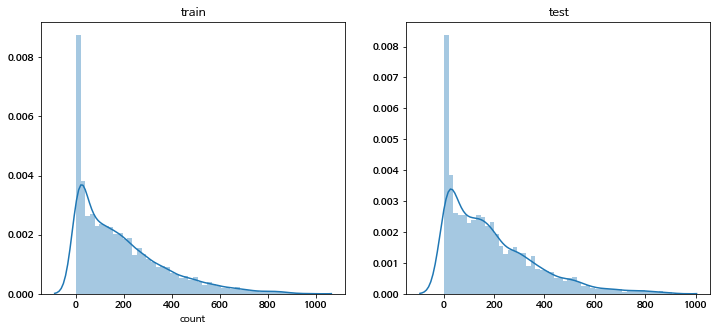

In [287]:
# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

In [288]:
submission = pd.read_csv(file_path+"/sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,10.250000
1,2011-01-20 01:00:00,5.590000
2,2011-01-20 02:00:00,4.360000
3,2011-01-20 03:00:00,3.623333
4,2011-01-20 04:00:00,2.780000


In [294]:
submission.to_csv(file_path+"/random_forest_임원기.csv", index=False)